In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

In [2]:
print("hello")

hello


In [3]:
df = pd.read_csv("../data/AirPassengers.csv")
df.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [7]:
series = TimeSeries.from_dataframe(df, time_col="Month", value_cols="#Passengers")

<Axes: xlabel='Month'>

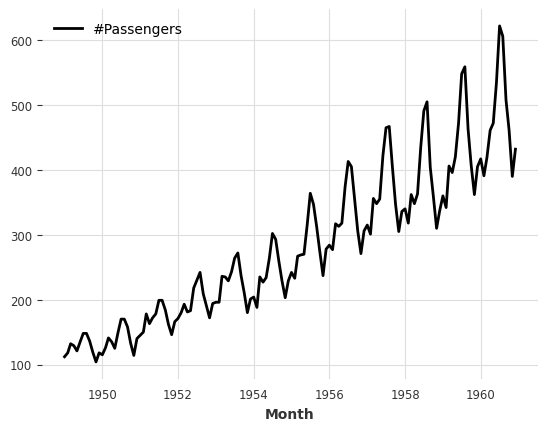

In [10]:
series.plot()